Linearized Model

Linearized Model Specifications
----------------------------------------------
NA 				: 0.8
Space Dimension 		: 32.000um × 32.000um × 8.000um
Voxel Size 			: 1.0um × 1.0um × 1.0um
Original Shape 			: 32 × 32 × 8
DMD Patch Size 			: 2.0um × 2.0um
DMD Patterns 			: 32
# of Plane			: 1
Detector Pool size 		: 2×2
Computational Device 		: cuda




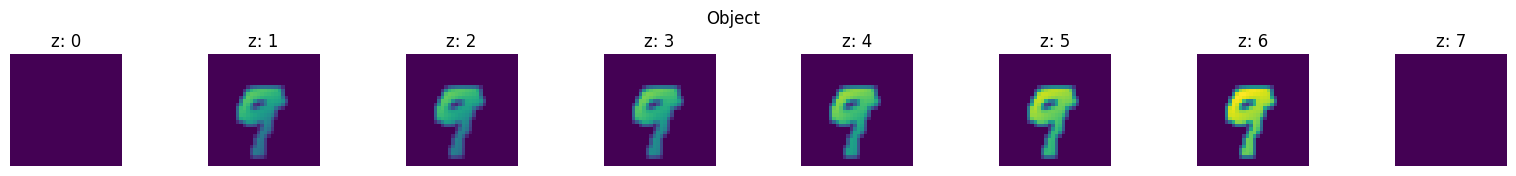

In [3]:
from libs.forward_lib.linearized_process import LinearizedModel
from libs.forward_lib.read_data import ReadData
import torch
import numpy as np

nx, ny, nz              = 32, 32, 8                    # Spatial Dimension
LM = LinearizedModel()
LM.load_matrix(it = 100, is_original=False)
print(LM)

n_measure = 1024
b = 343
X =  torch.load("./data/dataset/object/Xr_MNIST.pt")[b].to(LM.device)
y_clean  = torch.load("./data/dataset/measurement/Y_MNIST.pt")[b].to(LM.device)[:n_measure]

RD = ReadData(nx, ny, nz)
RD.X = X.view(1, nz, nx, ny)
RD.visualize_data(is_orginal=True)

X = X.cpu().numpy().reshape(32*32*8, 1)
y_clean = y_clean.cpu().numpy().reshape(n_measure, 1)
FM = LM.A.cpu().numpy()[:n_measure,:]



def add_gaussian_noise(signal, snr_dB):
    signal_power = np.mean(signal**2)
    snr = 10**(snr_dB/10.0)
    noise_power = signal_power/snr
    noise = np.random.randn(*signal.shape) * np.sqrt(noise_power)
    noisy_signal = signal + noise
    return noisy_signal

desired_snr_dB = 20.0
y_noisy = add_gaussian_noise(y_clean, desired_snr_dB).reshape(n_measure, 1)

### TWIST



Initial objective = 6993160740.984264, nonzeros = 0
Incrementing S = 2
Incrementing S = 4
Incrementing S = 8
Incrementing S = 16
Incrementing S = 32
Incrementing S = 64
Incrementing S = 128
Incrementing S = 256
Incrementing S = 512
Incrementing S = 1024
Incrementing S = 2048
Incrementing S = 4096
Incrementing S = 8192
Incrementing S = 16384
Incrementing S = 32768
Incrementing S = 65536
Incrementing S = 131072
Incrementing S = 262144
Incrementing S = 524288
Incrementing S = 1048576
Incrementing S = 2097152
Incrementing S = 4194304
Incrementing S = 8388608
Incrementing S = 16777216
Incrementing S = 33554432
Incrementing S = 67108864
Iteration = 2, objective = 4987386314.976421, nz = 8192, criterion = 286.8194369182392
Iteration = 3, objective = 4951833806.862944, nz = 8192, criterion = 7.128484915379126
Incrementing S = 134217728
Iteration = 4, objective = 201779096.87886146, nz = 8192, criterion = 959.2516419676267
Iteration = 5, objective = 181558012.8096322, nz = 8192, criterion = 10

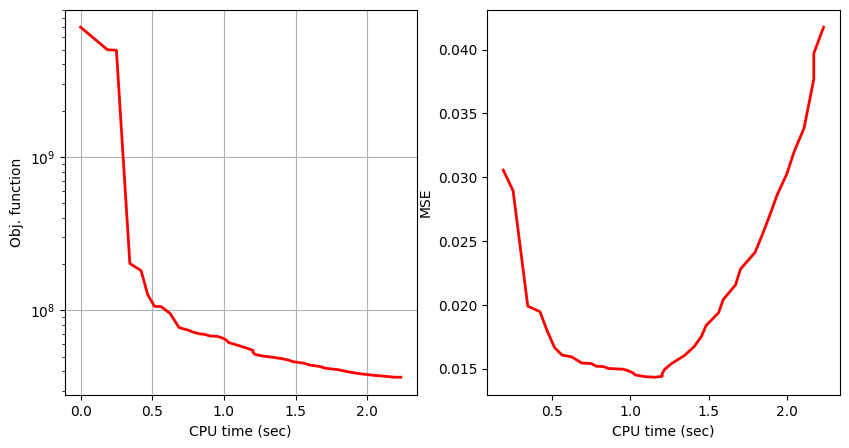

TwIST CPU time: 2.234375
MSE Loss: 4.1754e-02


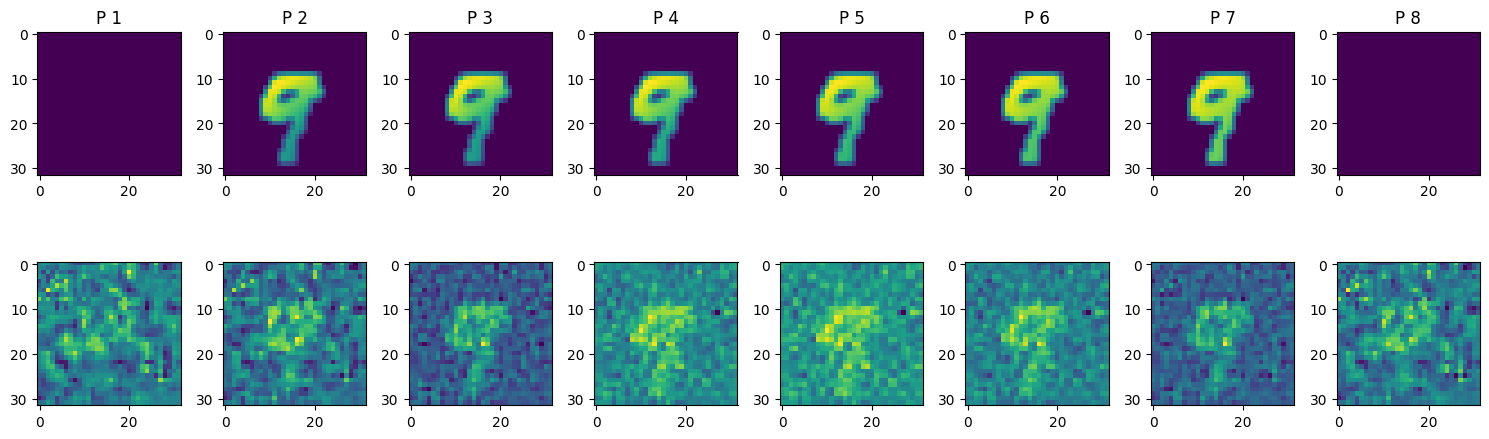

plane 1 | SSIM = 0.0108 | PSNR = 16.3869 dB
plane 2 | SSIM = 0.2063 | PSNR = 16.5654 dB
plane 3 | SSIM = 0.3727 | PSNR = 20.1657 dB
plane 4 | SSIM = 0.3108 | PSNR = 20.2285 dB
plane 5 | SSIM = 0.3420 | PSNR = 20.3776 dB
plane 6 | SSIM = 0.3779 | PSNR = 20.8275 dB
plane 7 | SSIM = 0.3634 | PSNR = 19.5044 dB
plane 8 | SSIM = 0.0131 | PSNR = 16.4874 dB


In [4]:
import libs.reconstruction_lib.TWIST as TWIST
import libs.reconstruction_lib.twist_utils as utils

y = y_noisy

# absAty = np.abs(utils.AT(y, FM, nx, ny, nz))
# tau = 1e-7*np.max(absAty) # Regularization parameter
tau = 1 # Regularization parameter
Psi = 'TV' # denoising function ('TV', 'SOFT', 'SOFT_DWT')
Phi = 'TV' # regularization function ('TV', 'L1', 'L1_DWT')
lam1 = 1e-5 # twist parameter
stop_criterion = 1 # 0:non-zero components, 1:change in obj func, 2:estimate, 3:value of obj func 
tolA = 1e-3 # Stopping threshold
init = 0 # 0:zero, 1:random, 2:Aty, 3:init_x given by user
init_x = None # initial estimate

x_twist, dummy, obj_twist, times_twist, dummy, mse_twist, dummy = TWIST.TwIST(y, FM, tau, nx, ny, nz,
                                                                                Psi=Psi, Phi=Phi,
                                                                                lam1=1e-4, alpha=0, beta=0,
                                                                                stop_criterion=stop_criterion, tolA=tolA,
                                                                                init=init, init_x=init_x,
                                                                                enforceMonotone=1,
                                                                                true_x=X, compute_mse=1,
                                                                                verbose=1)

utils.plot_obj_mse(obj_twist, times_twist, mse_twist, figsize=(10,5))

ssim_values, psnr_values = utils.comparison2(X, x_twist, nx, ny, nz, figsize=(15, 5), planes_to_plot=range(nz))

### Basic Reconstruction


In [5]:
# import libs.reconstruction_lib.twist_utils as utils
# x_recons = torch.linalg.pinv(LM.A)@torch.tensor(y_noisy).to(LM.device).float()
# ssim_values, psnr_values = utils.comparison2(X, x_recons.cpu().numpy().reshape(32*32*8,1), nx, ny, nz, figsize=(15, 5), planes_to_plot=range(nz))